In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from nltk.cluster import KMeansClusterer
import nltk

from node2vec import Node2Vec

sns.set_style('whitegrid')

In [2]:
dimensions = 128
walk_length = 80
num_walks = 10
p = 1.0
q = 1.0
workers = 4

window = 10
min_count = 1
seed = 0

# 1. Pure graph - nodes of the groups are linked only

In [3]:
pure_edges = pd.read_csv('../data/clear_cluster_test/pure_edges.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/clear_cluster_test/labels.csv', header=None, 
                     names=('node','label','label+'))
labels_list = list(labels['label'].unique())

n_clusters = len(labels['label'].unique())

In [4]:
pure_G = nx.Graph()
pure_G.add_nodes_from(labels['node'])

In [5]:
for i, row in pure_edges.iterrows():
    pure_G.add_edge(row['from'],row['to'], weight=1)

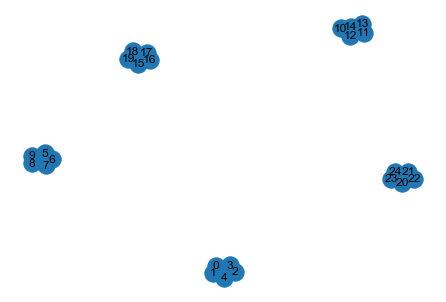

In [6]:
pos = nx.spring_layout(pure_G)
nx.draw(pure_G, pos=pos, with_labels=True, seed=seed)

In [7]:
def count_embeddings(G,labels,dimensions,walk_length,num_walks,p,q,workers,window,min_count,seed):
    n2v = Node2Vec(G, 
               dimensions = dimensions, 
               walk_length = walk_length,
               num_walks = num_walks,
               p = p,
               q = q,
               workers = workers
              )
    model = n2v.fit(window = window, 
                          min_count = min_count,
                          seed = seed
                         )
    model_nodes = list(model.wv.vocab)
    
    sorted_labels = []
    for i in model_nodes:
        sorted_labels.append(labels.loc[int(i)]['label'])

    return model,model_nodes,sorted_labels

In [8]:
def to2d(embedding_clusters,perplexity):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape

    tsne_model_en_2d = TSNE(perplexity=perplexity, n_components=2, random_state=seed)
    embeddings_en_2d = np.array(
    tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    return embeddings_en_2d

In [9]:
colors_dic = {
    0:'red',
    1:'orange',
    2:'black',
    3:'green',
    4:'blue'
    }

def assign_colors(pure_model_nodes,labels):
    colors = []
    for i in pure_model_nodes:
        colors.append(colors_dic[labels.loc[int(i)]['label']])
    return colors

In [10]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, colors, a, filename=None):
    plt.figure(figsize=(16, 9))
    
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=colors_dic[label], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=1, xy=(x[i]+2, y[i]+2), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=12)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [11]:
def count_scores(labels, clusters):
    f1_micro = metrics.f1_score(known_labels,km,average='micro')
    adj_score = metrics.adjusted_rand_score(known_labels,idx)
    return f1_micro, adj_score

In [12]:
pure_model,pure_model_nodes,pure_sorted_labels = count_embeddings(pure_G,labels,dimensions,
                                                                  walk_length,num_walks,p,q,workers,
                                                                  window,min_count,seed)

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 3127.65it/s]


In [13]:
pure_model.wv.vectors

array([[-0.40084976,  0.59137106,  0.56906193, ..., -0.13512222,
         0.26305073, -0.3233397 ],
       [ 0.2549457 ,  1.1022127 ,  0.0725826 , ...,  0.11905348,
         0.7936012 ,  0.051972  ],
       [ 0.46133664,  0.99012345, -0.28961822, ..., -0.709873  ,
        -0.21940324, -0.10737983],
       ...,
       [ 0.2822131 ,  1.1168549 ,  0.05967099, ...,  0.09600352,
         0.7945857 ,  0.04581085],
       [-0.36595324,  0.597013  ,  0.56090647, ..., -0.12649286,
         0.27584195, -0.32044327],
       [ 0.26760226, -0.15752195,  0.6748376 , ..., -0.06685029,
         0.2736666 , -0.38485992]], dtype=float32)

## 1.2 Clusterization by most_similar() function

Separetes the easy graph with the known and the same number of nodes in one group 100% right. 
But works only on those easy graps.

In [14]:
keys = list(range(0,24,5)) # the first node of each group

embedding_clusters = []
word_clusters = []
for word in keys:
    print('word ',word)
    embeddings = []
    words = []
    embeddings.append(pure_model[str(word)]) # adding vector of the first(key) node
    words.append(str(word)) # adding vector of the first(key) node
    for similar_word, prob in pure_model.most_similar(str(word), topn=4): # или добавлять в зависимости от вероятности 
        words.append(similar_word)
        print(similar_word)
        embeddings.append(pure_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

word  0
4
1
3
2
word  5
7
9
8
6
word  10
13
12
14
11
word  15
18
17
19
16
word  20
21
23
22
24


In [15]:
model_en_2d = to2d(embedding_clusters,5)

In [16]:
colors = assign_colors(pure_model_nodes,labels)

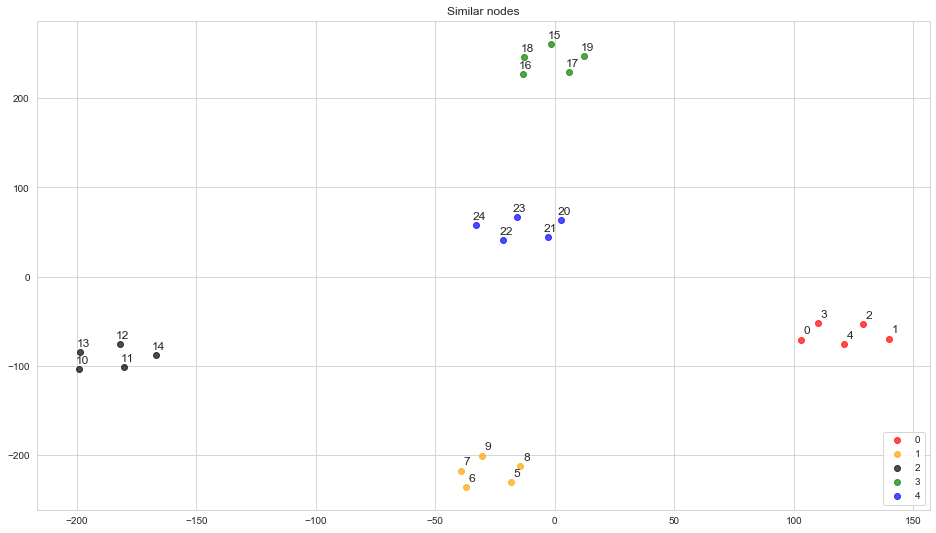

In [17]:
tsne_plot_similar_words('Similar nodes', labels_list, model_en_2d, word_clusters, colors, 0.7)

## 1.3 Clusterization by kmeans - cosine similarity distance

In [18]:
def kmeans_clustering(model,n_clusters):
    X = model.wv.vectors
    kclusterer = KMeansClusterer(n_clusters, distance=nltk.cluster.util.cosine_distance, repeats=30,
                                 avoid_empty_clusters=True)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
    return assigned_clusters

In [19]:
pure_assigned_clusters = kmeans_clustering(pure_model,n_clusters)

In [20]:
pure_assigned_clusters

[4, 3, 1, 2, 2, 3, 0, 1, 4, 0, 0, 3, 2, 0, 4, 1, 1, 2, 4, 0, 3, 1, 3, 4, 2]

In [21]:
words = list(pure_model.wv.vocab)
for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i, word in enumerate(words):
        if (pure_assigned_clusters[i]==cluster):
            print (word)

cluster:  0
4
1
23
24
17
cluster:  1
11
2
18
15
9
cluster:  2
10
13
21
19
8
cluster:  3
12
0
22
6
5
cluster:  4
14
3
20
16
7


In [22]:
# pure_model.wv.vectors == pure_model.wv.syn0

## 1.4 Clusterization with most_similar() function
- same as the previous one, but somehow works without the topn=4 parameter
- only for easy graphs -> unusable

In [23]:
# similar_words = {search_term: [item[0] for item in pure_model.wv.most_similar([search_term])]
#                  # ntop parametr was deleted and it worked for that graph
#                  # check if it works generaly 
#                   for search_term in ['0', '5', '10', '15', '20']}
# similar_words

# wvs = pure_model.wv[words]

# tsne = TSNE(n_components=2, random_state=seed, n_iter=10000, perplexity=5)
# np.set_printoptions(suppress=True)
# T = tsne.fit_transform(wvs)
# labels_words = words

# plt.figure(figsize=(14, 8))
# plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
# for label, x, y in zip(labels_words, T[:, 0], T[:, 1]):
#     plt.annotate(label, xy=(x+2, y+2), xytext=(0, 0), textcoords='offset points')

## 1.5 AffinityPropagation

In [24]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(pure_model.wv.vectors)
cluster_labels_affinity = ap.labels_

cluster_labels_affinity

array([4, 3, 0, 1, 1, 3, 2, 0, 4, 2, 2, 3, 1, 2, 4, 0, 0, 1, 4, 2, 3, 0,
       3, 4, 1], dtype=int64)

In [25]:
words = list(pure_model.wv.vocab)
for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i, word in enumerate(words):
        if (cluster_labels_affinity[i]==cluster):
            print (word)

cluster:  0
11
2
18
15
9
cluster:  1
10
13
21
19
8
cluster:  2
4
1
23
24
17
cluster:  3
12
0
22
6
5
cluster:  4
14
3
20
16
7


In [26]:
score = metrics.f1_score(pure_sorted_labels,pure_assigned_clusters,average='micro')
score

0.24

In [27]:
score = metrics.f1_score(pure_sorted_labels,cluster_labels_affinity,average='micro')
score

0.12

## 1.5 DBSCAN

In [28]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=3, min_samples=2).fit(pure_model.wv.vectors)
DBSCAN_clusters = clustering.labels_
print(DBSCAN_clusters)

[0 1 2 3 3 1 4 2 0 4 4 1 3 4 0 2 2 3 0 4 1 2 1 0 3]


In [29]:
words = list(pure_model.wv.vocab)
for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i, word in enumerate(words):
        if (DBSCAN_clusters[i]==cluster):
            print (word)


cluster:  0
14
3
20
16
7
cluster:  1
12
0
22
6
5
cluster:  2
11
2
18
15
9
cluster:  3
10
13
21
19
8
cluster:  4
4
1
23
24
17


In [30]:
score = metrics.f1_score(pure_sorted_labels,DBSCAN_clusters,average='micro')
score

0.28

## 1.6 Kmeans another try
__fit_predict - works!__ but the naming of clusters is wrong

In [31]:
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters=n_clusters, random_state=seed)
idx = kmeans_clustering.fit_predict(pure_model.wv.vectors)
word_centroid_map = dict(zip(pure_model.wv.index2word, idx))

for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i in word_centroid_map:
        if word_centroid_map[i] == cluster:
            print(i)


cluster:  0
22
21
20
23
24
cluster:  1
13
12
11
14
10
cluster:  2
18
19
17
16
15
cluster:  3
7
6
5
9
8
cluster:  4
0
3
1
4
2


In [32]:
known_labels = []

for i in pure_model.wv.index2word:
    known_labels.append(labels.loc[int(i)]['label'])
    
known_labels

[1, 3, 2, 4, 4, 3, 0, 2, 1, 0, 0, 3, 4, 0, 1, 2, 2, 4, 1, 0, 3, 2, 3, 1, 4]

In [33]:
idx

array([3, 2, 1, 0, 0, 2, 4, 1, 3, 4, 4, 2, 0, 4, 3, 1, 1, 0, 3, 4, 2, 1,
       2, 3, 0])

F1_micro is low even though the clusterization is perfect

In [34]:
f1_micro = metrics.f1_score(known_labels,idx,average='micro')
f1_micro


0.0

adjusted_rand_score is ok

In [35]:
adj_score = metrics.adjusted_rand_score(known_labels,idx)
adj_score

1.0

# 2. Looking for the right score metrics

##  2.1 Kmeans - naming of the labels
__centroids init__

In [36]:
kmean_init = []
# init kmeans centroids with the first nodes of each cluster: 
# keys = [0, 5, 10, 15, 20],
# so the cluster name is known and is right 
for i in keys:
    kmean_init.append(pure_model.wv[str(i)])
init = np.array(kmean_init)
    
km = KMeans(n_clusters=n_clusters,init=init).fit_predict(pure_model.wv.vectors)
# print(km)

km_map = dict(zip(pure_model.wv.index2word, km))

for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i in km_map:
        if km_map[i] == cluster:
            print(i)

cluster:  0
0
3
1
4
2
cluster:  1
7
6
5
9
8
cluster:  2
13
12
11
14
10
cluster:  3
18
19
17
16
15
cluster:  4
22
21
20
23
24


In [37]:
f1_micro = metrics.f1_score(known_labels,km,average='micro')
f1_micro

1.0

In [38]:
adj_score = metrics.adjusted_rand_score(known_labels,km)
adj_score

1.0

Well, when clusters are named right from the begining, then any metric must be fine.
Though, there is a problem with initialization of centroids. Since, kmeans clustering assumes spherical shapes of clusters, there might be errors in clusterization:
- when the data clusters are not spherical;
- randomly initialized centroids are not always the centre of the looking cluster.

## 2.2 sklearn.metrics.homogeneity_score

In [39]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score([0, 0, 1, 1], [1, 1, 0, 3])

0.9999999999999999

In [40]:
homogeneity_score(known_labels,km)

1.0

## 2.3 sklearn.metrics.accuracy_score

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score([0, 2, 1, 3], 
               [0, 1, 2, 3])

0.5

In [42]:
accuracy_score(known_labels,km)

1.0